In [ ]:
import pandas as pd

# Mount Google Drive to access the data file
from google.colab import drive
drive.mount('/content/drive')

# Load full dataset
hyperlinks = pd.read_csv('/content/drive/MyDrive/soc-redditHyperlinks-body.tsv', sep='\t')
# Show the first few rows
print(hyperlinks.head())

Mounted at /content/drive
  SOURCE_SUBREDDIT TARGET_SUBREDDIT  POST_ID            TIMESTAMP  \
0  leagueoflegends  teamredditteams  1u4nrps  2013-12-31 16:39:58   
1       theredlion           soccer   1u4qkd  2013-12-31 18:18:37   
2     inlandempire           bikela  1u4qlzs  2014-01-01 14:54:35   
3              nfl              cfb  1u4sjvs  2013-12-31 17:37:55   
4       playmygame          gamedev  1u4w5ss  2014-01-01 02:51:13   

   LINK_SENTIMENT                                         PROPERTIES  
0               1  345.0,298.0,0.75652173913,0.0173913043478,0.08...  
1              -1  101.0,98.0,0.742574257426,0.019801980198,0.049...  
2               1  85.0,85.0,0.752941176471,0.0235294117647,0.082...  
3               1  1124.0,949.0,0.772241992883,0.0017793594306,0....  
4               1  715.0,622.0,0.777622377622,0.00699300699301,0....  


In [ ]:
hyperlinks["DATETIME"] = pd.to_datetime(hyperlinks["TIMESTAMP"])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [ ]:
# Preview label distribution
label_counts = hyperlinks["LINK_SENTIMENT"].value_counts(normalize=True)
print("Label distribution (%):")
print(label_counts * 100)

Label distribution (%):
LINK_SENTIMENT
 1    92.64729
-1     7.35271
Name: proportion, dtype: float64


In [ ]:
# Filter out malformed entries
hyperlinks = hyperlinks.dropna(subset=["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "PROPERTIES", "LINK_SENTIMENT"])


In [ ]:
# Parse 86-dim text embeddings (stored as strings like '[0.1, 0.2, ...]')
hyperlinks["TEXT_VECTOR"] = hyperlinks["PROPERTIES"].apply(lambda x: np.array(eval(x)))

In [ ]:
# Normalize the text embeddings
embedding_matrix = np.stack(hyperlinks["TEXT_VECTOR"].values)
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embedding_matrix)
hyperlinks["NORM_TEXT_VECTOR"] = list(normalized_embeddings)


In [ ]:
# Label sentiment as +1 (positive or neutral) or -1 (negative)
hyperlinks["SENTIMENT_LABEL"] = hyperlinks["LINK_SENTIMENT"].apply(lambda s: -1 if s == -1 else 1)


In [ ]:
# Final dataset preview
print(hyperlinks[["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "DATETIME", "SENTIMENT_LABEL"]].head())

  SOURCE_SUBREDDIT TARGET_SUBREDDIT            DATETIME  SENTIMENT_LABEL
0  leagueoflegends  teamredditteams 2013-12-31 16:39:58                1
1       theredlion           soccer 2013-12-31 18:18:37               -1
2     inlandempire           bikela 2014-01-01 14:54:35                1
3              nfl              cfb 2013-12-31 17:37:55                1
4       playmygame          gamedev 2014-01-01 02:51:13                1


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

Number of nodes: 35776
Number of edges: 137821


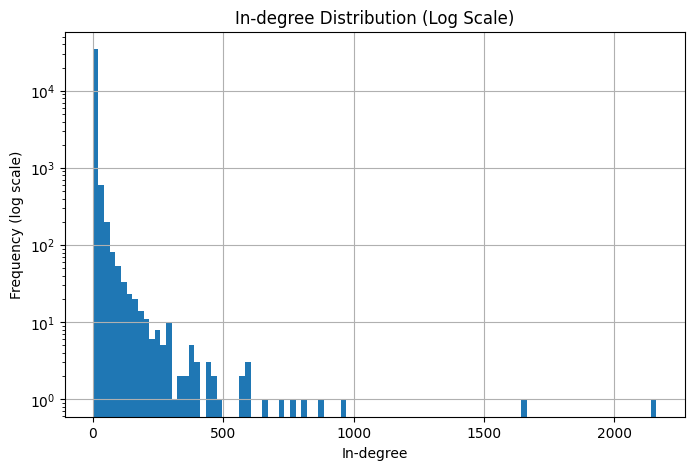

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with sentiment and timestamp attributes
for _, row in hyperlinks.iterrows():
    source = row["SOURCE_SUBREDDIT"]
    target = row["TARGET_SUBREDDIT"]
    sentiment = row["SENTIMENT_LABEL"]
    timestamp = row["DATETIME"]
    vector = row["NORM_TEXT_VECTOR"]

    # Add edge with sentiment and timestamp
    G.add_edge(source, target, sentiment=sentiment, timestamp=timestamp, text_vector=vector)

# Basic stats
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


# Compute in-degree distribution
in_degrees = [d for n, d in G.in_degree()]
plt.figure(figsize=(8, 5))
plt.hist(in_degrees, bins=100, log=True)
plt.title("In-degree Distribution (Log Scale)")
plt.xlabel("In-degree")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.show()

In [ ]:
import community as community_louvain

In [ ]:
in_degree_dict = dict(G.in_degree())
top_subreddits = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for subreddit, deg in top_subreddits:
    print(f"{subreddit}: {deg} in-links")

askreddit: 2161 in-links
iama: 1646 in-links
pics: 953 in-links
videos: 879 in-links
todayilearned: 816 in-links
funny: 757 in-links
writingprompts: 717 in-links
worldnews: 661 in-links
mhoc: 595 in-links
outoftheloop: 592 in-links


In [ ]:
# Filter for negative links only
negative_links = hyperlinks[hyperlinks["LINK_SENTIMENT"] == -1]

# Create a directed graph from negative links only
G_neg = nx.DiGraph()
G_neg.add_edges_from(zip(negative_links["SOURCE_SUBREDDIT"], negative_links["TARGET_SUBREDDIT"]))

# Compute negative in-degrees
neg_in_degree_dict = dict(G_neg.in_degree())
top_neg_subreddits = sorted(neg_in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for subreddit, deg in top_neg_subreddits:
    print(f"{subreddit}: {deg} negative in-links")

askreddit: 403 negative in-links
worldnews: 176 negative in-links
todayilearned: 165 negative in-links
news: 159 negative in-links
videos: 153 negative in-links
pics: 151 negative in-links
funny: 141 negative in-links
iama: 130 negative in-links
adviceanimals: 108 negative in-links
relationships: 102 negative in-links


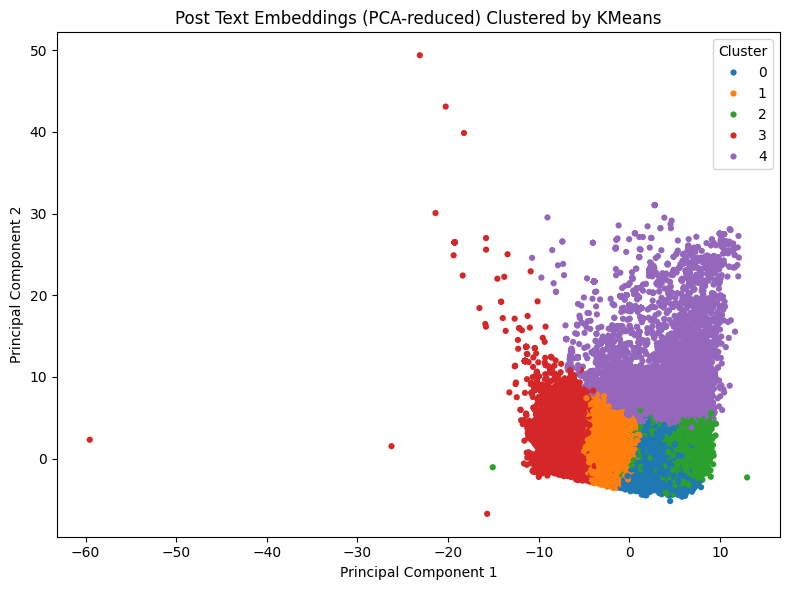

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

# Apply PCA to reduce 86-dim vectors to 2D for visualization
pca = PCA(n_components=2)
text_embeddings_2d = pca.fit_transform(np.stack(hyperlinks["NORM_TEXT_VECTOR"].values))
hyperlinks["PCA1"] = text_embeddings_2d[:, 0]
hyperlinks["PCA2"] = text_embeddings_2d[:, 1]

# Run KMeans clustering on original 86D vectors
kmeans = KMeans(n_clusters=5, random_state=42)
hyperlinks["TEXT_CLUSTER"] = kmeans.fit_predict(np.stack(hyperlinks["NORM_TEXT_VECTOR"].values))

# Plot PCA-reduced embeddings colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="TEXT_CLUSTER", palette="tab10", data=hyperlinks, s=20, linewidth=0)
plt.title("Post Text Embeddings (PCA-reduced) Clustered by KMeans")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
# Summary stats by cluster
cluster_summary = hyperlinks.groupby("TEXT_CLUSTER").agg({
    "SENTIMENT_LABEL": ["mean", "count"],
    "SOURCE_SUBREDDIT": lambda x: x.value_counts().index[0],
    "TARGET_SUBREDDIT": lambda x: x.value_counts().index[0],
}).reset_index()

cluster_summary.columns = ["Cluster", "AvgSentiment", "Size", "TopSourceSub", "TopTargetSub"]
print(cluster_summary)

   Cluster  AvgSentiment    Size     TopSourceSub    TopTargetSub
0        0      0.922726  107048      techsupport       askreddit
1        1      0.876565   73172   subredditdrama       askreddit
2        2      0.646265   46255      circlebroke       askreddit
3        3      0.862846   48923  shitliberalssay       askreddit
4        4      0.841978   11163  subreddit_stats  writingprompts


In [ ]:
from collections import Counter

# Only consider negative edges
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["sentiment"] == -1]

# Count number of negative links between each pair
neg_link_counts = Counter(neg_edges)

# Build directed conflict graph
conflict_graph = nx.DiGraph()
for (u, v), count in neg_link_counts.items():
    conflict_graph.add_edge(u, v, weight=count)

# Top aggressors (most targets)
top_aggressors = sorted(conflict_graph.out_degree(weight='weight'), key=lambda x: x[1], reverse=True)[:10]
print("Top Conflict Sources:")
for node, score in top_aggressors:
    print(f"{node}: {score} negative links to others")

# Top targets (most incoming hostility)
top_targets = sorted(conflict_graph.in_degree(weight='weight'), key=lambda x: x[1], reverse=True)[:10]
print("\nTop Conflict Targets:")
for node, score in top_targets:
    print(f"{node}: {score} negative links from others")

Top Conflict Sources:
subredditdrama: 427 negative links to others
drama: 262 negative links to others
copypasta: 129 negative links to others
circlejerkcopypasta: 123 negative links to others
circlebroke: 97 negative links to others
subredditcancer: 86 negative links to others
shitliberalssay: 86 negative links to others
conspiracy: 85 negative links to others
karmacourt: 70 negative links to others
writingprompts: 64 negative links to others

Top Conflict Targets:
askreddit: 186 negative links from others
worldnews: 107 negative links from others
todayilearned: 96 negative links from others
funny: 95 negative links from others
news: 95 negative links from others
videos: 92 negative links from others
pics: 78 negative links from others
adviceanimals: 71 negative links from others
iama: 65 negative links from others
subredditdrama: 61 negative links from others


In [ ]:
from collections import defaultdict
# Recompute conflict out/in counts from negative edges
conflict_out = defaultdict(int)
conflict_in = defaultdict(int)

for u, v, data in G.edges(data=True):
    if data["sentiment"] == -1:
        conflict_out[u] += 1
        conflict_in[v] += 1

# Create DataFrame
all_nodes = set(conflict_out.keys()).union(set(conflict_in.keys()))
conflict_df = pd.DataFrame({
    "subreddit": list(all_nodes),
    "conflict_out": [conflict_out.get(s, 0) for s in all_nodes],
    "conflict_in": [conflict_in.get(s, 0) for s in all_nodes],
})
conflict_df["conflict_total"] = conflict_df["conflict_out"] + conflict_df["conflict_in"]
conflict_df["net_aggression"] = conflict_df["conflict_out"] - conflict_df["conflict_in"]

# View top net aggressors
top_aggressors = conflict_df.sort_values(by="net_aggression", ascending=False).head(10)
print(top_aggressors[["subreddit", "conflict_out", "conflict_in", "net_aggression"]])

                subreddit  conflict_out  conflict_in  net_aggression
2425       subredditdrama           427           61             366
5091                drama           262           22             240
4146            copypasta           129            4             125
359   circlejerkcopypasta           123            2             121
985           circlebroke            97           12              85
2502      shitliberalssay            86            5              81
924            karmacourt            70            4              66
3917      subredditcancer            86           22              64
4523             badkarma            54            1              53
2881            openbroke            55            2              53


In [ ]:
# Mutual hostility: both (u, v) and (v, u) exist with weight > 0
mutual_pairs = []
for u, v in conflict_graph.edges():
    if conflict_graph.has_edge(v, u):
        mutual_pairs.append((u, v, conflict_graph[u][v]['weight'], conflict_graph[v][u]['weight']))

# Sort by total conflict volume
mutual_pairs_sorted = sorted(mutual_pairs, key=lambda x: x[2] + x[3], reverse=True)[:10]
print("\nTop Mutual Conflict Pairs:")
for u, v, w1, w2 in mutual_pairs_sorted:
    print(f"{u} ↔ {v}: {w1} / {w2} negative links")


Top Mutual Conflict Pairs:
subredditdrama ↔ atheism: 1 / 1 negative links
subredditdrama ↔ enoughlibertarianspam: 1 / 1 negative links
subredditdrama ↔ offmychest: 1 / 1 negative links
subredditdrama ↔ creepypms: 1 / 1 negative links
subredditdrama ↔ raldi: 1 / 1 negative links
subredditdrama ↔ enoughtrumpspam: 1 / 1 negative links
subredditdrama ↔ justunsubbed: 1 / 1 negative links
subredditdrama ↔ nostupidquestions: 1 / 1 negative links
offmychest ↔ askreddit: 1 / 1 negative links
offmychest ↔ subredditdrama: 1 / 1 negative links


In [ ]:

# Truncate to month
hyperlinks["MONTH"] = hyperlinks["DATETIME"].dt.to_period("M")

# Aggregate by month and sentiment
monthly_sentiment = hyperlinks.groupby(["MONTH", "SENTIMENT_LABEL"]).size().unstack(fill_value=0)

# Rename columns for clarity
monthly_sentiment.columns = ["Negative Links", "Positive/Neutral Links"]

monthly_sentiment.index = monthly_sentiment.index.to_timestamp()
monthly_sentiment.head()


,Negative Links,Positive/Neutral Links
MONTH,,
2013-12-01,1,6
2014-01-01,331,4109
2014-02-01,330,4101
2014-03-01,462,4921
2014-04-01,387,4603


from matplotlib import pyplot as plt
_df_0['Negative Links'].plot(kind='hist', bins=20, title='Negative Links')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Positive/Neutral Links'].plot(kind='hist', bins=20, title='Positive/Neutral Links')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Negative Links', y='Positive/Neutral Links', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Negative Links'].plot(kind='line', figsize=(8, 4), title='Negative Links')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Positive/Neutral Links'].plot(kind='line', figsize=(8, 4), title='Positive/Neutral Links')
plt.gca().spines[['top', 'right']].set_visible(False)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/sentiment_flow.png'

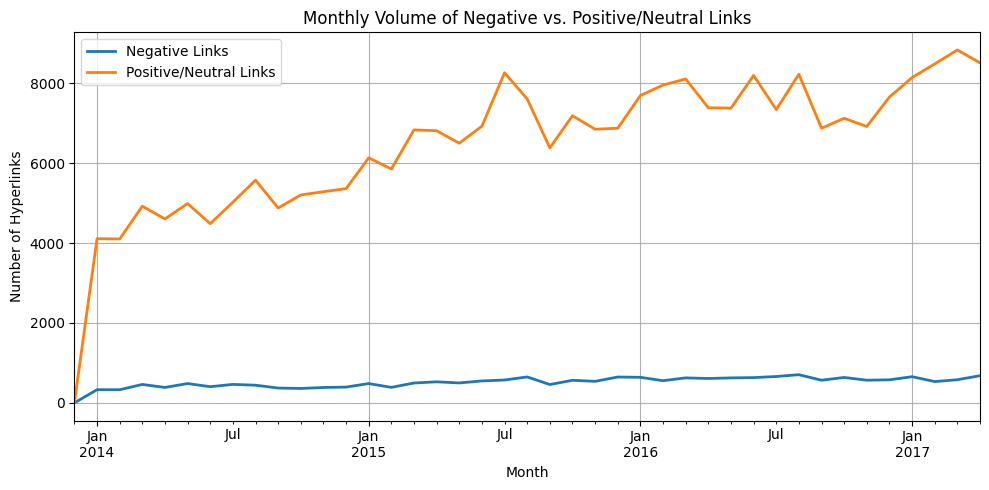

In [ ]:
monthly_sentiment.plot(figsize=(10, 5), linewidth=2)
plt.title("Monthly Volume of Negative vs. Positive/Neutral Links")
plt.xlabel("Month")
plt.ylabel("Number of Hyperlinks")
plt.grid(True)
plt.tight_layout()
plt.savefig("/mnt/data/sentiment_flow.png", dpi=300, bbox_inches='tight')
plt.show()

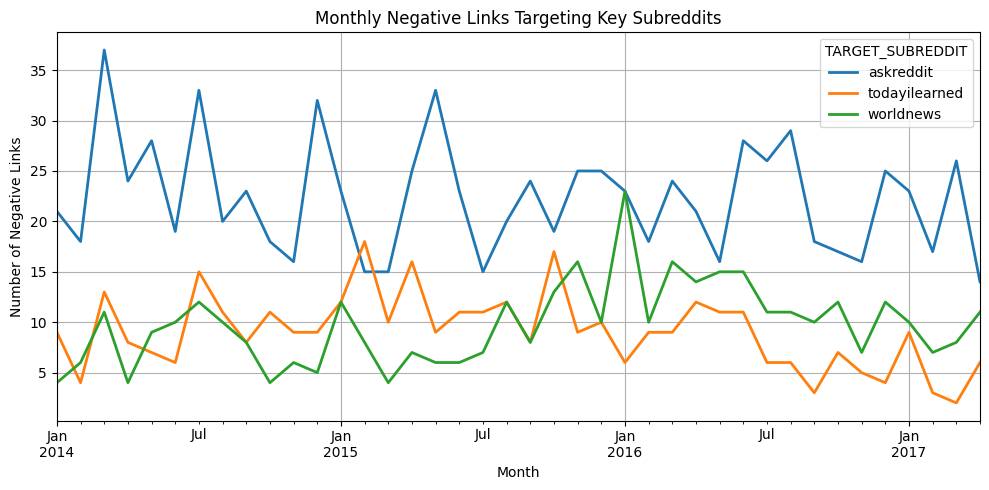

In [ ]:
# Filter for negative links and target subreddits of interest
target_subs = ["askreddit", "worldnews", "todayilearned"]
neg_df = hyperlinks[(hyperlinks["SENTIMENT_LABEL"] == -1) & (hyperlinks["TARGET_SUBREDDIT"].isin(target_subs))].copy()
neg_df["MONTH"] = neg_df["DATETIME"].dt.to_period("M")

# Group and pivot
neg_flow = (
    neg_df.groupby(["MONTH", "TARGET_SUBREDDIT"])
    .size()
    .unstack(fill_value=0)
)
neg_flow.index = neg_flow.index.to_timestamp()

# Plot
neg_flow.plot(figsize=(10, 5), linewidth=2)
plt.title("Monthly Negative Links Targeting Key Subreddits")
plt.xlabel("Month")
plt.ylabel("Number of Negative Links")
plt.grid(True)
plt.tight_layout()
plt.savefig("neg_sentiment_targets.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# Count negative links per month
monthly_counts = neg_df.groupby("MONTH").size()

# Find month with min and max
min_month = monthly_counts.idxmin()
min_count = monthly_counts.min()

max_month = monthly_counts.idxmax()
max_count = monthly_counts.max()

print(f"Lowest number of negative links: {min_count} in {min_month}")
print(f"Highest number of negative links: {max_count} in {max_month}")

Lowest number of negative links: 27 in 2017-02
Highest number of negative links: 61 in 2014-03
